<a href="https://colab.research.google.com/github/nshamid/Face-Mask-Detection/blob/main/Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from PIL import Image as PILImage
from tensorflow.keras.preprocessing import image

In [ ]:
dataset_path = '/content/Face Mask Dataset.zip'
extract_path = '/content/face-mask-dataset'

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
base_dir = '/content/face-mask-dataset/Face Mask Dataset'

# Data Augmentation dan Splitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)  # 80% training, 20% validation

# Load data Training dan Validation
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation')

Found 1053 images belonging to 2 classes.
Found 262 images belonging to 2 classes.


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

epochs = 10
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.6237 - loss: 0.6185 - val_accuracy: 0.8626 - val_loss: 0.3306
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.8529 - loss: 0.3643 - val_accuracy: 0.8931 - val_loss: 0.2681
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8615 - loss: 0.3324 - val_accuracy: 0.9122 - val_loss: 0.2252
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8996 - loss: 0.2795 - val_accuracy: 0.9542 - val_loss: 0.1264
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9365 - loss: 0.2087 - val_accuracy: 0.9504 - val_loss: 0.1185
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9165 - loss: 0.2358 - val_accuracy: 0.9198 - val_loss: 0.1739
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9087 - loss: 0.2200 - val_accuracy: 0.9504 - val_loss: 0.1587
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9404 - loss: 0.1562 - val_accuracy: 0.9504 - val_loss:

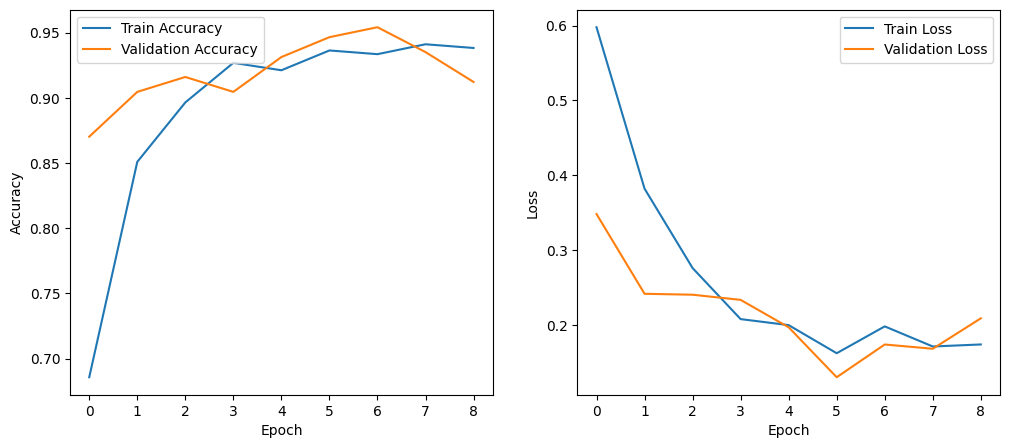

In [ ]:
#PLot Training dan Validation Accuracy dan Loss
def plot_learning_curves(history):
  plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  plt.plot(history.history['accuracy'], label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

plot_learning_curves(history)

Saving mentahan_foto.jpg to mentahan_foto.jpg


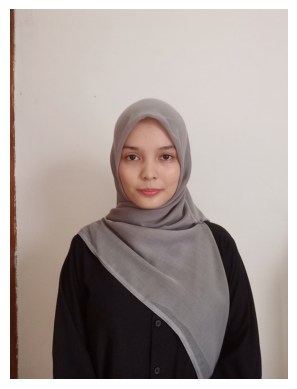

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediksi: Without Mask


In [ ]:
# Fungsi Prediksi
def predict_mask(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    if prediction[0][0] > 0.5:
        return "Prediksi: Without Mask"
    else:
        return "Prediksi: With Mask"

uploaded = files.upload()

# Loop
for fn in uploaded.keys():
    path = fn

    # Menampilkan Gambar
    img = PILImage.open(path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    result = predict_mask(path)
    print(result)

In [ ]:
#Evaluasi Model
validation_generator.reset()
y_true = validation_generator.classes
y_pred = (model.predict(validation_generator) > 0.5).astype("int32").flatten()

#Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['With Mask', 'Without Mask']))

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step
Classification Report:
              precision    recall  f1-score   support

   With Mask       0.54      0.56      0.55       131
Without Mask       0.54      0.52      0.53       131

    accuracy                           0.54       262
   macro avg       0.54      0.54      0.54       262
weighted avg       0.54      0.54      0.54       262



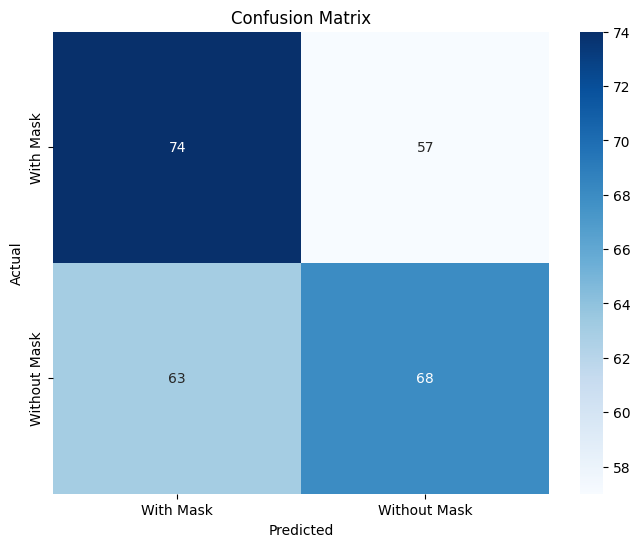

In [ ]:
#Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['With Mask', 'Without Mask'], yticklabels=['With Mask', 'Without Mask'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


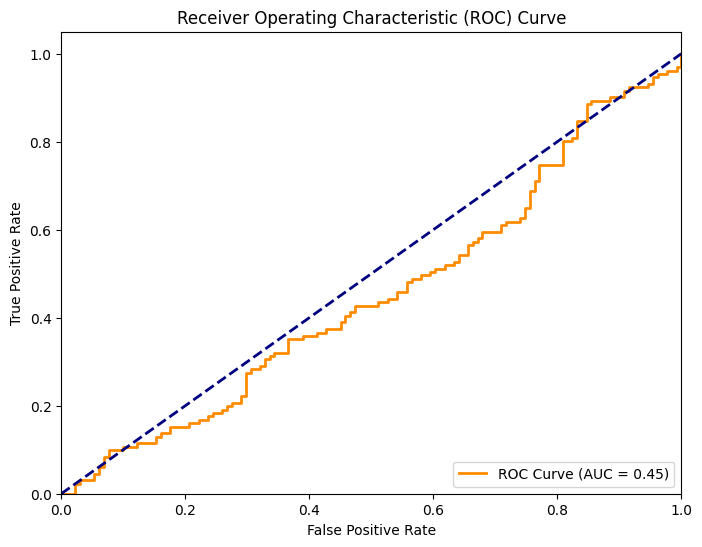

In [ ]:
#ROC Curve dan AUC
y_pred_proba = model.predict(validation_generator).ravel()
fpr, tpr, _=roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()